In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import HTML

In [85]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import matplotlib
matplotlib.rc('font', size=16)
pandas.options.display.float_format = '{:,.3f}'.format
from seaborn import plotting_context

In [3]:
from evaluate import load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_multiple_grad_cam, get_expert_results

Using TensorFlow backend.
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

In [4]:
from data import describe, all_features, data, print_describe, load_single
from run import characterize_data
from config import config

# Parameters

In [5]:
DIRECTORY = os.path.join(os.environ["DATA_DIR"], "liver-ultrasound")
MODEL_UUID = "04cfb42d-3e0b-4516-aa85-56f19cb4d6b9"
MODEL_TYPE = "v2"
SELECTIONS = "None"
PARAMETERS_ID = "parameters"

In [6]:
# Parameters
DIRECTORY = "/media/user1/my4TB/intrepidlemon/liver-ultrasound/free"
MODEL_UUID = "04cfb42d-3e0b-4516-aa85-56f19cb4d6b9"
MODEL_TYPE = "v2"
SELECTIONS = "[]"
PARAMETERS_ID = "free-complete"


In [7]:
SELECTIONS = eval(SELECTIONS)
FEATURES = config.FEATURES
RAW = "{}/raw".format(DIRECTORY)
TRAIN = "{}/train".format(DIRECTORY)
VALIDATION = "{}/validation".format(DIRECTORY)
MODEL = "{}/models/{}-{}.h5".format(config.OUTPUT, MODEL_UUID, MODEL_TYPE)

## Lesion descriptions

In [8]:
train, validation, test = data(shuffle_train=False, validation_dir=VALIDATION, train_dir=TRAIN)

Found 660 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Found 172 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [9]:
print("training data breakdown: ", characterize_data(train))
print("validation data breakdown: ", characterize_data(validation))
print("validation data breakdown: ", characterize_data(test))

training data breakdown:  {'benign': 280, 'malignant': 380}
validation data breakdown:  {'benign': 64, 'malignant': 108}
validation data breakdown:  {'benign': 41, 'malignant': 41}


In [10]:
len(train)

42

In [11]:
print(validation.n)

172


In [12]:
model = load(MODEL)

In [13]:
results = get_results(model, test)

In [14]:
results

array([[0.9667642 ],
       [0.9775    ],
       [0.37962133],
       [0.4253345 ],
       [0.48385367],
       [0.8401759 ],
       [0.9821212 ],
       [0.9717059 ],
       [0.99996376],
       [0.62718403],
       [0.05095611],
       [0.8835817 ],
       [0.7860929 ],
       [0.11109896],
       [0.9839864 ],
       [0.16774441],
       [0.08546603],
       [0.7089216 ],
       [0.98856187],
       [0.02832211],
       [0.81233734],
       [0.3830409 ],
       [0.1979341 ],
       [0.03626407],
       [0.68094045],
       [0.05089889],
       [0.05675178],
       [0.04809595],
       [0.15441372],
       [0.03428024],
       [0.05617381],
       [0.00910551],
       [0.01987776],
       [0.16500624],
       [0.1310193 ],
       [0.04498778],
       [0.02873398],
       [0.2730986 ],
       [0.03588186],
       [0.69707745],
       [0.08281362],
       [0.69328773],
       [0.23801051],
       [0.910467  ],
       [0.9931397 ],
       [0.996687  ],
       [0.99464947],
       [0.785

In [15]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(test)

## Accuracy and loss

In [16]:
loss, accuracy = calculate_accuracy_loss(model, test)
print("Accuracy:", accuracy)
print("Loss:", loss)

Accuracy: 0.6463414634146342
Loss: 0.9016227664017096


## Confusion matrix

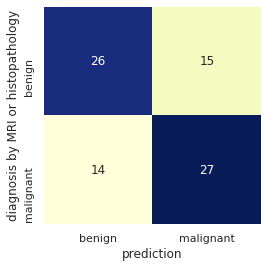

In [17]:
fig = plot_confusion_matrix(test, results)
fig.savefig("figures/{}-confusion-matrix.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [18]:
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=test.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR
benign,0.646,26,27,14,15,0.634,0.659,0.650,0.643,0.341,0.366,0.350
malignant,0.646,27,26,15,14,0.659,0.634,0.643,0.650,0.366,0.341,0.357


## ROC Curve standalone

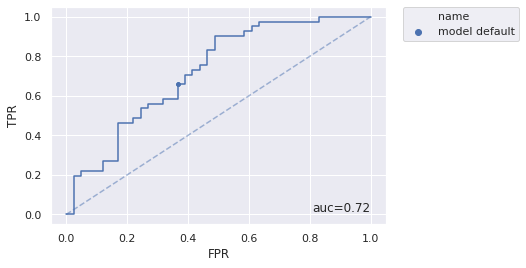

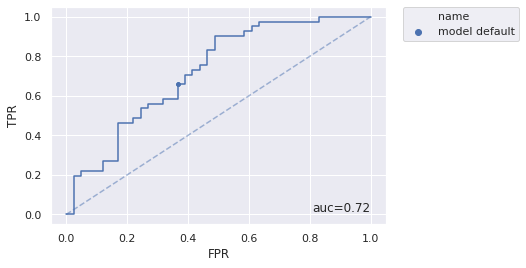

In [19]:
plot_roc_curve(labels, results)

In [20]:
print("ROC AUC:", roc_auc_score(labels, probabilities))

ROC AUC: 0.7221891731112433


## Precision Recall

In [21]:
print("Average precision:", average_precision_score(labels, probabilities))
print("Precision:", precision_score(labels, predictions), "Recall:", recall_score(labels, predictions))

Average precision: 0.6797214612517307
Precision: 0.6428571428571429 Recall: 0.6585365853658537


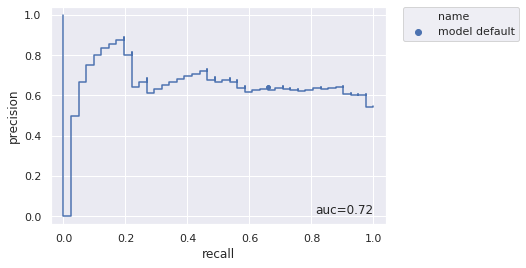

In [22]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-precision-recall.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [23]:
print("PR AUC:", calculate_pr_auc(labels, results))

PR AUC: 0.6645005566465557


## F1 Score

In [24]:
print("F1 score:", f1_score(labels, predictions))

F1 score: 0.6506024096385543


## TSNE

In [25]:
diagnosis, malignancy, evidence = all_features(features=FEATURES)

In [66]:
malignancy

{'id': 'malignant',
 '29511670': 'benign',
 '29610400': 'benign',
 '29800047': 'benign',
 '29780003': 'benign',
 '29812667': 'benign',
 '29352155': 'benign',
 '29777878': 'benign',
 '29877372': 'benign',
 '29880642': 'benign',
 '29848352': 'benign',
 '29882310': 'benign',
 '29917777': 'benign',
 '29945752': 'benign',
 '29973960': 'benign',
 '30030860': 'benign',
 '29314117': 'benign',
 '30041917': 'benign',
 '30047885': 'benign',
 '15957948': 'benign',
 '15899132': 'benign',
 '15427145': 'benign',
 '15447071': 'benign',
 '14499072': 'benign',
 '15549574': 'benign',
 '15390275': 'benign',
 '15579240': 'benign',
 '15634000': 'benign',
 '15154878': 'benign',
 '15705324': 'benign',
 '15764983': 'benign',
 '15265143': 'benign',
 '15779715': 'benign',
 '26184437': 'benign',
 '27217906': 'benign',
 '26935222': 'benign',
 '26971610': 'benign',
 '26420142': 'benign',
 '26424318': 'benign',
 '16031566': 'benign',
 '15946996': 'benign',
 '15996115': 'benign',
 '15573577': 'benign',
 '15626731': '

In [51]:
tsne_dataset = train

In [68]:
tsne_dataset.reset()

In [69]:
train_results = get_results(model, tsne_dataset)
train_predictions = ["malignant" if t else "benign" for t in transform_binary_predictions(train_results)]

In [70]:
tsne_labels = [
    [malignancy.get(accession_from_filename(f), "unknown") for f in tsne_dataset.filenames], 
    train_predictions
]

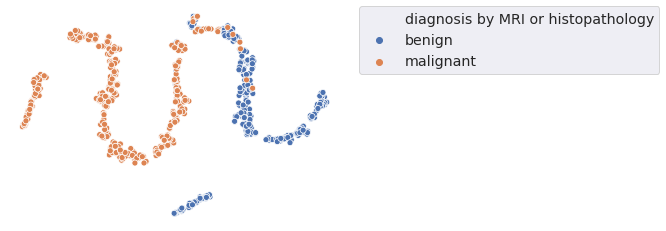

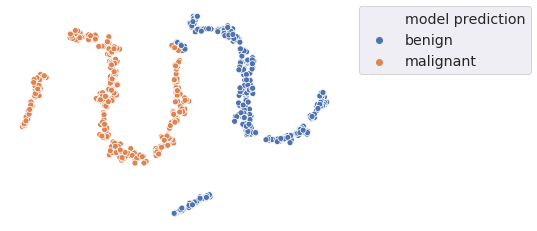

In [89]:
with plotting_context("notebook", font_scale=1.3): 
    tsne_dataset.reset()
    fig = plot_tsne(model, "dense_5", tsne_dataset, tsne_labels, perplexity=10, fieldnames=["diagnosis by MRI or histopathology", "model prediction"])
    fig[0].savefig("figures/label-{}-tsne.svg".format(PARAMETERS_ID), bbox_inches = "tight")
    fig[1].savefig("figures/model-{}-tsne.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [55]:
train_results

array([[3.06365602e-02],
       [8.76276661e-03],
       [1.75083522e-02],
       [1.50804026e-05],
       [3.36854458e-02],
       [4.62299613e-06],
       [2.67984718e-02],
       [3.12521704e-03],
       [2.43952155e-01],
       [6.75291598e-01],
       [7.49096796e-02],
       [1.89186022e-01],
       [2.37112679e-02],
       [5.33124655e-02],
       [4.24594671e-01],
       [3.04947108e-01],
       [5.54498553e-01],
       [3.36663797e-02],
       [5.49059187e-05],
       [4.22065943e-01],
       [2.58737594e-01],
       [3.39817852e-02],
       [3.65550432e-06],
       [3.25791421e-03],
       [3.49644572e-01],
       [2.58749332e-02],
       [1.11549757e-01],
       [3.62982282e-05],
       [2.25890934e-01],
       [9.86235123e-03],
       [3.65954038e-04],
       [5.15277348e-02],
       [2.66947409e-05],
       [4.62855241e-04],
       [1.78089924e-02],
       [6.70318067e-01],
       [5.22766232e-01],
       [1.85506076e-01],
       [4.03856568e-04],
       [7.72436783e-02],


## Experts

In [31]:
get_expert_results("evaluations/radiology-3344.json", test.filenames)

error with benign/fixed-27026916.jpeg: '27026916.jpeg'
error with benign/fixed-27808351.jpeg: '27808351.jpeg'
error with benign/fixed-27954713-1.jpeg: '27954713-1.jpeg'
error with benign/fixed-27954713-2.jpeg: '27954713-2.jpeg'
error with benign/fixed-6041779.jpeg: '6041779.jpeg'
error with benign/fixed-7363540-1.jpeg: '7363540-1.jpeg'
error with benign/fixed-8217457-1.jpeg: '8217457-1.jpeg'
error with malignant/fixed-5829440.jpeg: '5829440.jpeg'
error with malignant/fixed-7221037.jpeg: '7221037.jpeg'
error with malignant/fixed-7336509.jpeg: '7336509.jpeg'
error with malignant/fixed-7343132.jpeg: '7343132.jpeg'
error with malignant/fixed-7419872.jpeg: '7419872.jpeg'
error with malignant/fixed-7486948-1.jpeg: '7486948-1.jpeg'
error with malignant/fixed-7486948-2.jpeg: '7486948-2.jpeg'
error with malignant/fixed-7486948-3.jpeg: '7486948-3.jpeg'
error with malignant/fixed-7486948-4.jpeg: '7486948-4.jpeg'
error with malignant/fixed-7637848-1.jpeg: '7637848-1.jpeg'
error with malignant/fixe

['benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'malignant',
 None,
 'benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 None,
 'benign',
 'malignant',
 None,
 None,
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 None,
 None,
 None,
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

error with benign/free-26805873.jpeg: '26805873.jpeg'
error with benign/free-27026916.jpeg: '27026916.jpeg'
error with benign/free-27244981.jpeg: '27244981.jpeg'
error with benign/free-4782399.jpeg: '4782399.jpeg'
error with malignant/free-26699890-1.jpeg: '26699890-1.jpeg'
error with malignant/free-26699890-2.jpeg: '26699890-2.jpeg'
error with malignant/free-26699890-3.jpeg: '26699890-3.jpeg'
error with malignant/free-26699890.jpeg: '26699890.jpeg'
error with malignant/free-26943899-1.jpeg: '26943899-1.jpeg'
error with malignant/free-26943899-2.jpeg: '26943899-2.jpeg'
error with malignant/free-26998526-1.jpeg: '26998526-1.jpeg'
error with malignant/free-26998526-2.jpeg: '26998526-2.jpeg'
error with malignant/free-26998526-3.jpeg: '26998526-3.jpeg'
error with malignant/free-26998526.jpeg: '26998526.jpeg'
error with malignant/free-27251611-1.jpeg: '27251611-1.jpeg'
error with malignant/free-27251611-2.jpeg: '27251611-2.jpeg'
error with malignant/free-27251611-3.jpeg: '27251611-3.jpeg'
e

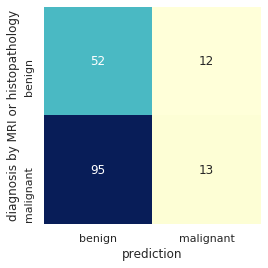

In [32]:
expert_1, fig = plot_expert_confusion("evaluations/radiology-9809.json", validation)
fig.savefig("figures/{}-confusion-matrix-expert-1.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [33]:
pandas.DataFrame(expert_1, index=validation.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR
benign,0.378,52,13,95,12,0.812,0.120,0.354,0.520,0.880,0.188,0.646
malignant,0.378,13,52,12,95,0.120,0.812,0.520,0.354,0.188,0.880,0.480


## ROC with experts

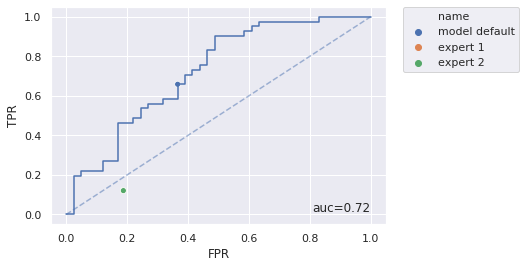

In [34]:
fig = plot_roc_curve(labels, results, experts=[{ **expert_1, "name":"expert 1" }, { **expert_1, "name":"expert 2" }])
fig.savefig("figures/{}-roc-curve.svg".format(PARAMETERS_ID), bbox_inches = "tight")

In [35]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')